In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import pyfolio as pf

C:\Users\shahc\anaconda3\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


Start date,2019-01-31
End date,2024-10-04
Total months,66
,Backtest
Annual return,-56.125%
Cumulative returns,-98.964%
Annual volatility,12039.951%
Sharpe ratio,1.97
Calmar ratio,-0.56
Stability,0.00
Max drawdown,-99.975%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,99.98,2019-05-06,2020-03-19,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


C:\Users\shahc\anaconda3\lib\site-packages\pyfolio\timeseries.py:1235: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
Covid,86.81%,-98.50%,6544.51%


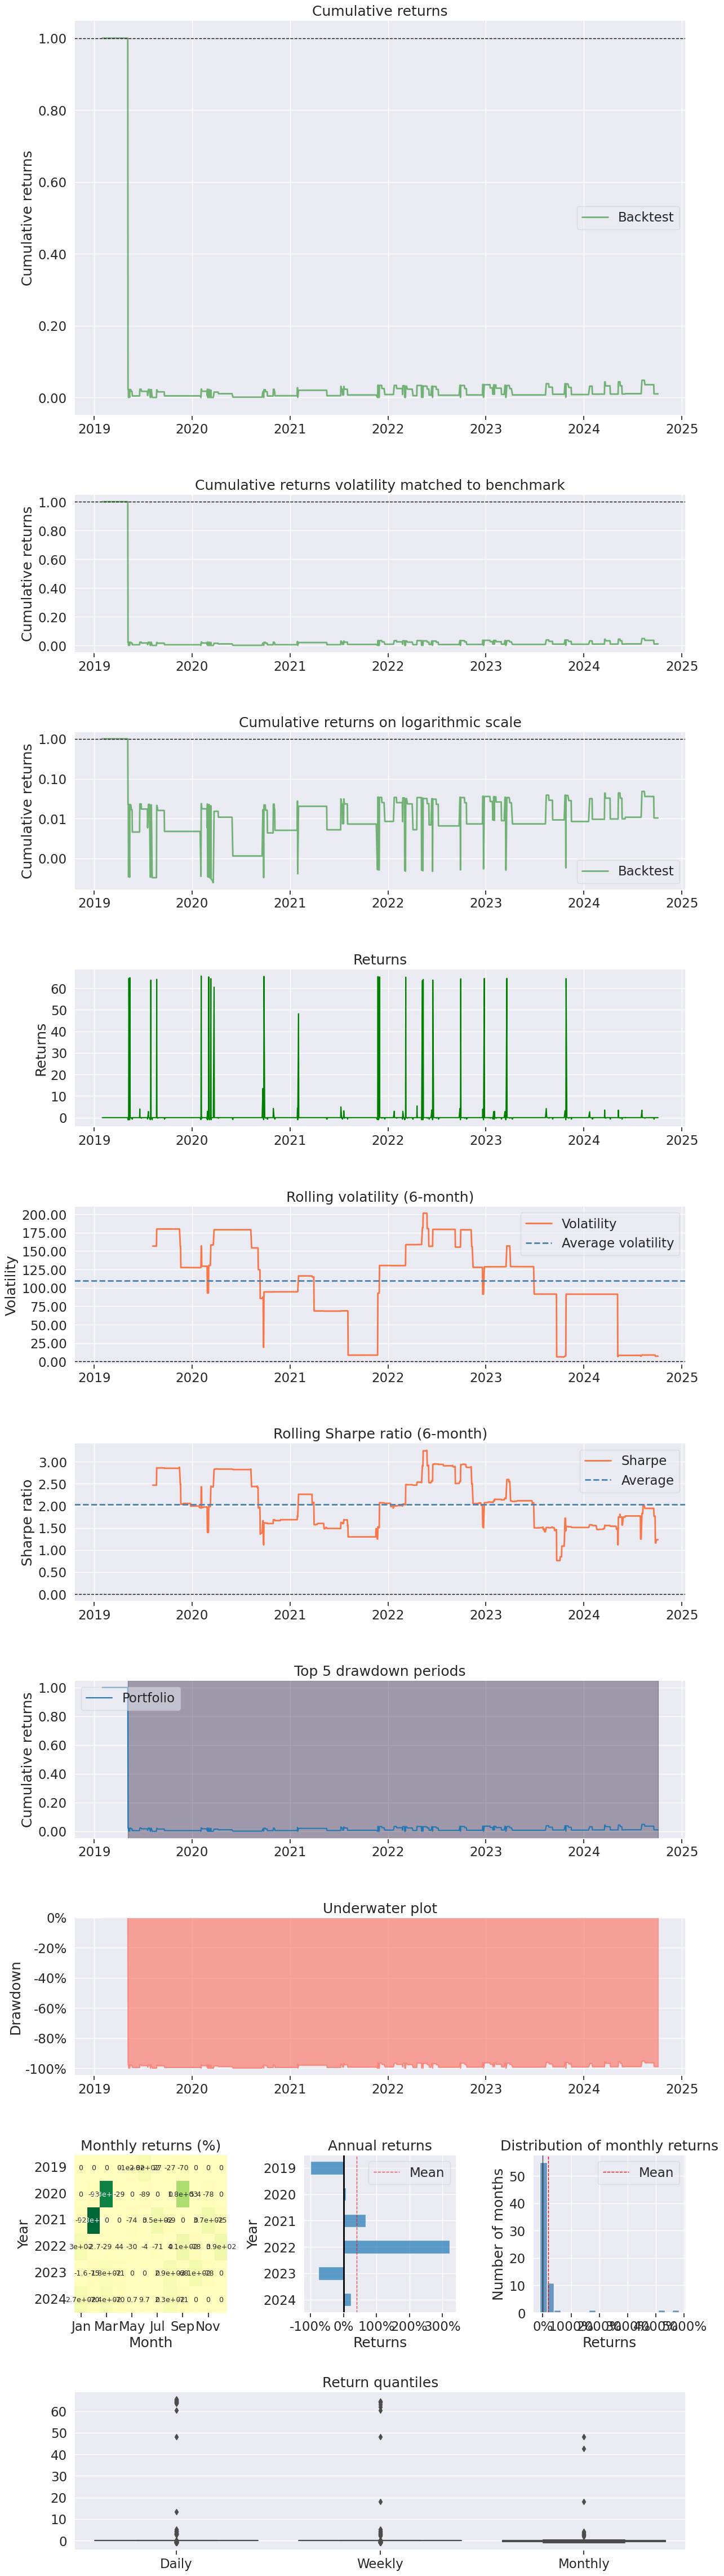

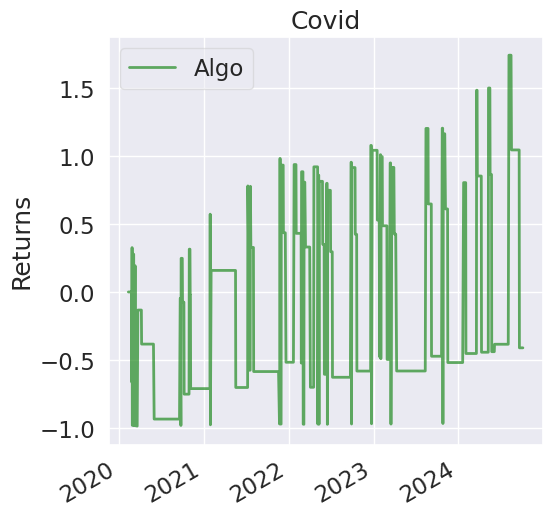

In [5]:
# Download historical data using yfinance
ticker = '^NSEI'  # Example: NSE Index (replace with your preferred ticker)
data = yf.download(ticker, start='2019-01-01', end='2024-12-31')

# Parameters
length = 20
mult = 2.0
stop_loss_perc = 1.5 / 100
  # Starting portfolio value (1,000,000)

# Bollinger Bands Calculation
data['basis'] = data['Close'].rolling(window=length).mean()
data['stddev'] = data['Close'].rolling(window=length).std()
data['upper_band'] = data['basis'] + (mult * data['stddev'])
data['lower_band'] = data['basis'] - (mult * data['stddev'])

# Initialize trade variables
trade_in_progress = 0
entry_price = np.nan
stop_loss = np.nan
portfolio_value = initial_portfolio_value
all_trades = []  # Store all trades
portfolio_values = []  # To store portfolio value after each trade
dates = []  # To store corresponding dates

# Simulate the strategy
for i in range(length, len(data)):
    close_price = data['Close'].iloc[i]
    open_price = data['Open'].iloc[i]
    High = data['High'].iloc[i]
    Low = data['Low'].iloc[i]
    upper_band = data['upper_band'].iloc[i]
    lower_band = data['lower_band'].iloc[i]
    middle_band = data['basis'].iloc[i]
    
    # Entry condition
    if Low <= lower_band and trade_in_progress == 0:
        entry_price = lower_band
        stop_loss = entry_price * (1 - stop_loss_perc)
        trade_in_progress = 2
        all_trades.append((data.index[i], 'Entry', lower_band))
        portfolio_value = 2*entry_price  # Update portfolio on entry

    # Partial exit at middle Bollinger Band
    if High >= middle_band and trade_in_progress == 2:
        all_trades.append((data.index[i], '50% Exit', middle_band))
        #stop_loss = entry_price  Move stop loss to breakeven
        trade_in_progress = 1
        portfolio_value -= middle_band * 0.5  # Add 50% of the position to portfolio value

    # Final exit at upper Bollinger Band
    if trade_in_progress > 0 and High >= upper_band:
        all_trades.append((data.index[i], 'Final Exit', upper_band))
        portfolio_value -= upper_band  # Add remaining position to portfolio value
        trade_in_progress = 0

    # Stop loss enforcement
    if trade_in_progress == 1 and Low <= stop_loss:
        all_trades.append((data.index[i], 'Stop Loss Hit', stop_loss))
        portfolio_value -= stop_loss  # Update portfolio value on stop loss
        trade_in_progress = 0
    
    if trade_in_progress == 2 and Low <= stop_loss:
        all_trades.append((data.index[i], 'Stop Loss Hit', stop_loss))
        portfolio_value -= 2*stop_loss  # Update portfolio value on stop loss
        trade_in_progress = 0

    # Track portfolio value for each day
    portfolio_values.append(portfolio_value)
    dates.append(data.index[i])

# Step 1: Create DataFrame with portfolio values
portfolio_df = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values
})

# Step 2: Calculate daily returns (percentage change)
portfolio_df['daily_returns'] = portfolio_df['portfolio_value'].pct_change()

# Set 'date' as index
portfolio_df.set_index('date', inplace=True)

# Drop NaN values (if any, from the first day due to pct_change)
portfolio_df.dropna(inplace=True)

# Step 3: Analyze using PyFolio
pf.create_full_tear_sheet(portfolio_df['daily_returns'])





In [ ]:
# Calculate portfolio values and analyze trades
portfolio_value = 0
for trade in all_trades:
    date, action, price = trade
    if action == 'Entry':
        portfolio_value -= entry_price  # Buy at entry price
    elif action == '50% Exit':
        portfolio_value += price * 0.5  # Sell 50% at middle band
    elif action == 'Final Exit':
        portfolio_value += price  # Sell remaining at upper band
    elif action == 'Stop Loss Hit':
        portfolio_value += price  # Liquidate at stop loss

    portfolio_values.append(portfolio_value)

# Create candlestick chart with Plotly
candlestick = go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name='OHLC',
    increasing_line_color='green', 
    decreasing_line_color='red'
)

# Bollinger Bands
upper_band_trace = go.Scatter(
    x=data.index, 
    y=data['upper_band'], 
    line=dict(color='rgba(255, 0, 0, 0.75)', width=1.5), 
    name='Upper Bollinger Band'
)

middle_band_trace = go.Scatter(
    x=data.index, 
    y=data['basis'], 
    line=dict(color='blue', width=1.5), 
    name='Middle Bollinger Band'
)

lower_band_trace = go.Scatter(
    x=data.index, 
    y=data['lower_band'], 
    line=dict(color='rgba(0, 255, 0, 0.75)', width=1.5), 
    name='Lower Bollinger Band'
)

# Add trade markers for entries, exits, and stop losses
trade_markers = []
for trade in all_trades:
    date, action, price = trade
    if action == 'Entry':
        trade_markers.append(go.Scatter(
            x=[date],
            y=[price],
            mode='markers',
            marker=dict(color='blue', size=10, symbol='triangle-up'),
            name='Entry'
        ))
    elif action == '50% Exit':
        trade_markers.append(go.Scatter(
            x=[date],
            y=[price],
            mode='markers',
            marker=dict(color='purple', size=10, symbol='triangle-down'),
            name='50% Exit'
        ))
    elif action == 'Final Exit':
        trade_markers.append(go.Scatter(
            x=[date],
            y=[price],
            mode='markers',
            marker=dict(color='red', size=10, symbol='triangle-down'),
            name='Final Exit'
        ))
    elif action == 'Stop Loss Hit':
        trade_markers.append(go.Scatter(
            x=[date],
            y=[price],
            mode='markers',
            marker=dict(color='orange', size=10, symbol='x'),
            name='Stop Loss Hit'
        ))

# Layout for the chart
layout = go.Layout(
    title=f"Bollinger Bands and OHLC for {ticker}",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

# Combine all traces and plot
fig = go.Figure(data=[candlestick, upper_band_trace, middle_band_trace, lower_band_trace] + trade_markers, layout=layout)
fig.show()


In [ ]:
def calculate_portfolio_value_with_reinvestment(initial_investment=1000000):
    current_investment = initial_investment
    shares_held = 0
    gross_profit = 0
    gross_loss = 0
    winning_trades = 0
    losing_trades = 0
    total_trades_closed = 0
    portfolio_value_history = []
    partial_sell = False  # Track if 50% sell happened
    
    for i in range(1, len(all_trades)):
        prev_trade = all_trades[i - 1]
        current_trade = all_trades[i]
        
        # Entry Trade - Buy shares with current investment
        if prev_trade[1] == 'Entry':
            entry_price = prev_trade[2]
            shares_held = current_investment / entry_price
            partial_sell = False  # Reset the partial sell flag

        # Partial Exit - Sell 50% of shares
        if current_trade[1] == '50% Exit':
            exit_price = current_trade[2]
            profit_loss = (exit_price - entry_price) * (shares_held / 2)  # Half of the shares sold
            current_investment += profit_loss  # Add profit/loss from 50% sale
            partial_sell = True  # Mark that 50% sell happened
            gross_profit += max(profit_loss, 0)
            gross_loss += abs(min(profit_loss, 0))

        # Full Exit or Stop Loss Hit - Sell remaining shares
        if current_trade[1] in ['Final Exit', 'Stop Loss Hit']:
            exit_price = current_trade[2]
            remaining_shares = shares_held / 2 if partial_sell else shares_held  # Half if 50% sold, else all shares
            profit_loss = (exit_price - entry_price) * remaining_shares
            current_investment += profit_loss  # Add profit/loss from remaining shares
            total_trades_closed += 1
            
            # Log profit or loss
            if profit_loss > 0:
                gross_profit += profit_loss
                winning_trades += 1
            else:
                gross_loss += abs(profit_loss)
                losing_trades += 1
            
            # Record portfolio value after each trade
            portfolio_value_history.append((current_trade[0], current_investment))
    
    net_profit = current_investment - initial_investment
    return portfolio_value_history, net_profit, gross_profit, gross_loss, winning_trades, losing_trades, total_trades_closed

# Call the function to calculate portfolio value with reinvestment
portfolio_value_history, net_profit, gross_profit, gross_loss, winning_trades, losing_trades, total_trades_closed = calculate_portfolio_value_with_reinvestment()

# Print the portfolio stats
print(f"Net Profit: {net_profit}")
print(f"Gross Profit: {gross_profit}")
print(f"Gross Loss: {gross_loss}")
print(f"Total Trades Closed: {total_trades_closed}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")

# Optionally, print the portfolio value history for each trade
for date, value in portfolio_value_history:
    print(f"Date: {date}, Portfolio Value: {value}")


In [6]:
def print_trade_details(all_trades, portfolio_values):
    print(f"{'Date':<15} {'Action':<20} {'Price':<10} {'Portfolio Value':<15}")
    print("-" * 70)  # Updated separator line
    for trade, portfolio_value in zip(all_trades, portfolio_values):
        date, action, price = trade
        print(f"{date.strftime('%Y-%m-%d'):<15} {action:<20} {price:.2f} {portfolio_value:.2f}")
        
print_trade_details(all_trades, portfolio_values)

Date            Action               Price      Portfolio Value
----------------------------------------------------------------------
2019-05-07      Entry                11504.52 1000000.00
2019-05-09      Stop Loss Hit        11331.96 1000000.00
2019-05-10      Entry                11313.44 1000000.00
2019-05-13      Stop Loss Hit        11143.74 1000000.00
2019-05-14      Entry                11171.13 1000000.00
2019-05-20      50% Exit             11514.35 1000000.00
2019-05-23      Final Exit           11986.54 1000000.00
2019-06-20      Entry                11635.15 1000000.00
2019-06-26      50% Exit             11852.04 1000000.00
2019-07-19      Stop Loss Hit        11460.62 1000000.00
2019-07-22      Entry                11335.21 1000000.00
2019-07-29      Stop Loss Hit        11165.18 1000000.00
2019-07-31      Entry                11007.44 1000000.00
2019-08-05      Stop Loss Hit        10842.33 1000000.00
2019-08-22      Entry                10749.33 1000000.00
2019-08-26

In [ ]:
# Plotting the portfolio value history
def plot_portfolio_value(portfolio_value_history):
    dates = [trade[0] for trade in portfolio_value_history]
    values = [trade[1] for trade in portfolio_value_history]
    
    portfolio_trace = go.Scatter(
        x=dates,
        y=values,
        mode='lines',
        name='Portfolio Value',
        line=dict(color='yellow', width=2)
    )
    
    layout = go.Layout(
        title="Portfolio Value Over Time (with Reinvestment)",
        xaxis_title="Date",
        yaxis_title="Portfolio Value",
        template="plotly_dark"
    )
    
    fig = go.Figure(data=[portfolio_trace], layout=layout)
    fig.show()

# Plot the portfolio value graph
plot_portfolio_value(portfolio_value_history)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf

# Fetch Nifty50 historical data using yfinance
nifty_ticker = '^NSEI'  # Nifty 50 index ticker
data = yf.download(nifty_ticker, start='2020-01-01', end='2023-01-01')
data = data[['Close']]  # We will use the closing prices
data.rename(columns={'Close': 'close'}, inplace=True)

# Calculate returns
data['returns'] = data['close'].pct_change()
data.dropna(inplace=True)

# Calculate Bollinger Bands
window = 20  # Rolling window for the SMA
data['sma'] = data['close'].rolling(window=window).mean()
data['std_dev'] = data['close'].rolling(window=window).std()
data['upper_band'] = data['sma'] + (data['std_dev'] * 2)
data['middle_band'] = data['sma']  # This is the middle band (SMA)
data['lower_band'] = data['sma'] - (data['std_dev'] * 2)

# Initialize investment parameters
initial_investment = 10000
data['investment_value'] = initial_investment
position = 0  # 0 = no position, 1 = long, 2 = partially long, -1 = short, -2 = partially short
partial_sell_amount = 0.5  # Amount to sell when hitting the middle band

# Backtest the strategy
for i in range(1, len(data)):
    if data['close'].iloc[i] <= data['lower_band'].iloc[i] and position == 0:  # Buy
        position = 1
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 + data['returns'].iloc[i])
        
    elif data['close'].iloc[i] >= data['middle_band'].iloc[i] and position == 1:  # Partial Sell
        position = 2  # Move to partially invested
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 + data['returns'].iloc[i] * partial_sell_amount)

    elif data['close'].iloc[i] >= data['upper_band'].iloc[i] and position in [1, 2]:  # Complete Sell
        position = 0
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 + data['returns'].iloc[i])

    elif data['close'].iloc[i] >= data['upper_band'].iloc[i] and position == 0:  # Short Sell
        position = -1  # Enter short position
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 - data['returns'].iloc[i])
        
    elif data['close'].iloc[i] <= data['middle_band'].iloc[i] and position == -1:  # Cover Partial Short
        position = -2  # Move to partially covered
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 - data['returns'].iloc[i] * partial_sell_amount)

    elif data['close'].iloc[i] <= data['lower_band'].iloc[i] and position in [-1, -2]:  # Cover Full Short
        position = 0
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 - data['returns'].iloc[i])
        
    else:
        # Maintain current value if not trading
        data['investment_value'].iloc[i] = data['investment_value'].iloc[i-1] * (1 + data['returns'].iloc[i] if position == 1 else (1 - data['returns'].iloc[i] if position == -1 else 1))

# Get the final investment value
final_value = data['investment_value'].iloc[-1]
profit = final_value - initial_investment

print(f"Final Investment Value: ${final_value:.2f}")
print(f"Total Profit: ${profit:.2f}")

# Create performance statistics with Pyfolio
daily_returns = data['returns'] * (
    (data['close'] <= data['lower_band']).shift(1) * 1 + 
    (data['close'] >= data['upper_band']).shift(1) * -1
)

pf.create_simple_tear_sheet(daily_returns)

# Plotting the Bollinger Bands and price
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue')
plt.plot(data['upper_band'], label='Upper Band', color='red', linestyle='--')
plt.plot(data['middle_band'], label='Middle Band (SMA)', color='orange', linestyle='--')
plt.plot(data['lower_band'], label='Lower Band', color='green', linestyle='--')
plt.fill_between(data.index, data['lower_band'], data['upper_band'], color='lightgrey', alpha=0.5)
plt.title('Bollinger Bands and Nifty50 Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\shahc\AppData\Local\Temp\ipykernel_3516\172910317.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Close': 'close'}, inplace=True)
C:\Users\shahc\AppData\Local\Temp\ipykernel_3516\172910317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'] = data['close'].pct_change()
C:\Users\shahc\AppData\Local\Temp\ipykernel_3516\172910317.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Final Investment Value: $8110.32
Total Profit: $-1889.68


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''